In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F    
from torch.optim import AdamW
from torch.optim import ASGD
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# from tqdm.notebook import tqdm
import random
import time

from typing import Optional, Dict, Any
import json
import os

CHECKPOINT_DIR = os.path.join("checkpoints", "neural_bigram")
LOG_DIR = os.path.join("logs", "neural_bigram")
RESULTS_DIR = os.path.join("results", "neural_bigram")

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)


In [2]:
from neural_bigram_ import NeuralBigram, init_dataloader, WarmupThenCosine, TextDataset
from bpe_hf import train_bytelevel_bpe, load_tokenizer, SPECIAL_TOKENS
from config import TrainConfig

In [3]:
def set_seed(seed: int = 1337, deterministic: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True


def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())


def save_checkpoint(state: Dict[str, Any], path: str, **kwargs):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(state, path, **kwargs)

def load_checkpoint(path: str, map_location="cpu", **kwargs) -> Dict[str, Any]:
    return torch.load(path, map_location=map_location, **kwargs)

In [4]:
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> Dict[str, float]:
    model.eval()
    total_nll = 0.0
    total_tok = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x, logits=True)                
        B, T, V = logits.shape
        # CE on logits here is equavilant to NLL
        nll_sum = F.cross_entropy(
            logits.reshape(B*T, V), y.reshape(B*T), reduction="sum"
        )
        total_nll += nll_sum.item()
        total_tok += B * T

    mean_nll = total_nll / max(1, total_tok)    
    # for perplexity, exponentiate the mean NLL
    return mean_nll

def train(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    cfg: TrainConfig,
    resume_from: Optional[str] = None,
    optimizer: Optional[torch.optim.Optimizer] = None,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    scaler: Optional[GradScaler] = None,
    writer: Optional[SummaryWriter] = None,
    eval=True,
    verbose: bool = False,
) -> Dict[str, Any]:

    set_seed(cfg.seed)
    device = cfg.device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if verbose:
        print(f"Device: {device} | Params: {count_params(model):,}")

    total_steps = cfg.epochs * max(1, len(train_loader) // max(1, cfg.grad_accum_steps))

    if optimizer is None:
        optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    if scheduler is None:
        scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-6)
    if scaler is None:
        scaler = GradScaler(enabled=cfg.use_amp)    

    start_epoch = 0
    best_val_ppl = float("inf")
    best_train_ppl = float("inf")
    no_improve = 0
    if resume_from and os.path.exists(resume_from):
        ckpt = load_checkpoint(resume_from, map_location=device)
        model.load_state_dict(ckpt["model"])
        optimizer.load_state_dict(ckpt["optimizer"])
        scheduler.load_state_dict(ckpt["scheduler"])
        scaler.load_state_dict(ckpt["scaler"])
        start_epoch = ckpt["epoch"] + 1
        best_val_ppl = ckpt.get("best_val_ppl", best_val_ppl)
        no_improve = ckpt.get("no_improve", 0)
        if verbose:
            print(f"Resumed from {resume_from} (epoch {start_epoch})")

    #### training loop ####
    history = {"train_loss": [], "train_ppl":[], "val_ppl": [], "val_loss": []}
    pbar_epoch = tqdm(range(start_epoch, cfg.epochs), 
                      total=cfg.epochs, desc="Training Progress", leave=True)
    stop_early = False
    for epoch in pbar_epoch:
        model.train(True)
        running_loss = 0.0
        running_loss_sum = 0.0
        running_tok = 0
        optimizer.zero_grad(set_to_none=True)

        pbar = tqdm(enumerate(train_loader), 
                    total=len(train_loader), desc=f"Epoch {epoch+1}/{cfg.epochs}", leave=False)
        for step, (x, y) in pbar:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            with autocast(device_type=cfg.device, enabled=cfg.use_amp):
                logits = model(x, logits=True)           # (B, T, V)
                B, T, V = logits.shape
                loss = F.cross_entropy(
                    logits.view(B * T, V),
                    y.view(B * T),
                    reduction="mean",
                )
                # for comparative nll log
                loss_sum = F.cross_entropy(
                    logits.view(B * T, V),
                    y.view(B * T),
                    reduction="sum",
                )

            # scale loss for gradient accumulation
            loss_to_backprop = loss / cfg.grad_accum_steps
            scaler.scale(loss_to_backprop).backward()
            if (step + 1) % cfg.grad_accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                scheduler.step() 

            running_loss += loss.item()
            running_tok  += B * T

            train_avg_loss = running_loss / max(1, running_tok)
            
            running_loss_sum += loss_sum.item()
            train_avg_loss_sum = running_loss_sum / max(1, running_tok)
            
            # write model graph to TensorBoard
            if writer is not None:
                if epoch == start_epoch and step == 0:
                    try:
                        writer.add_graph(model, x)
                    except Exception:
                        pass  
                global_step = epoch * len(train_loader) + step
                # current LR (first param group)
                writer.add_scalar("train/learning_rate", scheduler.get_last_lr()[0], global_step)
                writer.add_scalar("train/loss_step_mean", loss.item(), global_step)
                writer.add_scalar("train/loss_step_sum", loss_sum.item(), global_step)


        # model.train(False)

        train_ppl = np.exp(train_avg_loss_sum)

        if not eval:
            # early stopping check on training ppl
            if train_ppl < best_train_ppl - cfg.early_stop_tolerance:
                best_train_ppl = train_ppl
                no_improve = 0
            else:
                no_improve += 1
                if verbose:
                    print(f"No improvement ({no_improve}/{cfg.early_stop_patience}).")
                if cfg.early_stop_patience and no_improve >= cfg.early_stop_patience:
                    stop_early = True

        #### model evaluation ####
        val_avg_loss = evaluate(model, val_loader, device)
        # train_avg_loss = evaluate(model, train_loader, device)
        val_ppl = np.exp(val_avg_loss)

        # early stopping check on validation ppl
        if val_ppl < best_val_ppl - cfg.early_stop_tolerance:
            no_improve = 0
        else:
            no_improve += 1
            if verbose:
                print(f"No improvement ({no_improve}/{cfg.early_stop_patience}).")
            if cfg.early_stop_patience and no_improve >= cfg.early_stop_patience:
                stop_early = True

        #### logging ####
        history["train_loss"].append(train_avg_loss_sum)
        history["train_ppl"].append(train_ppl)
        history["val_loss"].append(val_avg_loss)
        history["val_ppl"].append(val_ppl)

        # checkpoint
        if val_ppl < best_val_ppl or (epoch + 1) % cfg.ckpt_n_epochs == 0 or epoch == cfg.epochs - 1:
            ckpt_path = cfg.ckpt_last_path
            if val_ppl < best_val_ppl:  
                best_val_ppl = val_ppl # update best perplexity
                ckpt_path = cfg.ckpt_best_path

            save_checkpoint(
                {
                    "epoch": epoch,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                    "scaler": scaler.state_dict(),
                    "best_val_ppl": best_val_ppl,
                    "no_improve": no_improve,
                    "config": vars(cfg),
                },
                ckpt_path,)

        pbar_epoch.set_postfix(
            train_loss=f"{train_avg_loss_sum:.4f}",
            train_ppl=f"{train_ppl:.2f}",
            val_loss=f"{val_avg_loss:.4f}",
            val_ppl=f"{val_ppl:.2f}",
            no_improve=f"{no_improve}/{cfg.early_stop_patience}" if cfg.early_stop_patience else "N/A",
        )

        if writer is not None:
            writer.add_scalars("epoch/loss", {
                "train_loss": train_avg_loss_sum,
                "val_loss": val_avg_loss,
            }, epoch)
            writer.add_scalars("epoch/ppl", {
                "train_ppl": train_ppl,
                "val_ppl": val_ppl,
            }, epoch)
            
            if (epoch % cfg.ckpt_n_epochs) == 0:
                for name, p in model.named_parameters():
                    writer.add_histogram(f"weights/{name}", p.data, epoch)

        if stop_early:
            if verbose:
                print(f"Early stopping at epoch {epoch + 1}.")
            break

    if writer is not None:
        writer.flush()
        writer.close()
        
    return {
        "history": history,
        "best_val_ppl": best_val_ppl,
        "last_epoch": epoch,
        "ckpt_best": cfg.ckpt_best_filename,
        "ckpt_last": cfg.ckpt_last_filename,
    }


In [5]:
data_dir = "../data/"
train_file = "Shakespeare_clean_train.txt"
train_file = os.path.join(data_dir, train_file)
test_file = "Shakespeare_clean_test.txt"
test_file = os.path.join(data_dir, test_file)
val_file = "Shakespeare_clean_valid.txt"
val_file = os.path.join(data_dir, val_file)

with open(train_file, "r", encoding="utf-8") as f:
    train_text = f.read().strip()

with open(test_file, "r", encoding="utf-8") as f:
    test_text = f.read().strip()

with open(val_file, "r", encoding="utf-8") as f:
    val_text = f.read().strip()

In [22]:
N_MERGES = 1200
MIN_FREQ = 2
SPECIAL_TOKENS = SPECIAL_TOKENS.copy()
PAD_TOKEN = SPECIAL_TOKENS.get("pad", "<pad>")
BOS_TOKEN = SPECIAL_TOKENS.get("bos", "<bos>")
EOS_TOKEN = SPECIAL_TOKENS.get("eos", "<eos>")


bpe_tokenizer = train_bytelevel_bpe(files=[train_file],
                                merges=N_MERGES, 
                                min_frequency=MIN_FREQ,
                                special_tokens=SPECIAL_TOKENS,
                                lowercase=False,
                                add_prefix_space=True,
                                name=f"bpe_shakespeare_{N_MERGES}")

encode = bpe_tokenizer.encode
decode = bpe_tokenizer.decode
vocab_size = bpe_tokenizer.get_vocab_size()
print("vocab size: ", vocab_size)
print("BPE tokenizer vocab: ", list(bpe_tokenizer.get_vocab().items())[:100])

PAD_TOKEN_ID = bpe_tokenizer.token_to_id(PAD_TOKEN) 
BOS_TOKEN_ID = bpe_tokenizer.token_to_id(BOS_TOKEN)
EOS_TOKEN_ID = bpe_tokenizer.token_to_id(EOS_TOKEN)

train_ids = encode(train_text).ids
test_ids = encode(test_text).ids
val_ids = encode(val_text).ids

print("train text charachters length: ", len(train_text))
print("train text words count: ", len(train_text.split()))
print("train ids length: ", len(train_ids))
print("train text first 100 chars: ", train_text[:100])
print("train ids first 100 ids: ", train_ids[:100])
print("train ids first 100 individual tokens: ", [bpe_tokenizer.id_to_token(i) for i in train_ids[:100]]) 




vocab size:  1460
BPE tokenizer vocab:  [('Ġbus', 1350), ('ĠSHY', 1080), ('ĠBRUT', 804), ('al', 363), ('Ġun', 589), ('Ġtrue', 880), ('Ġca', 567), ('oo', 342), ('ċ', 203), ('º', 122), ('Ġke', 865), ('@', 35), ('ĠLAERT', 1357), ('are', 606), ('Ġp', 298), ('i', 76), ('out', 467), ('Ġhold', 1091), ('Ġhea', 681), ('NO', 580), ('es', 282), ('ven', 493), ('ĠHow', 677), ('air', 1291), ('Ġsh', 424), ("'t", 624), ('«', 108), ('ime', 616), ('Ġname', 1057), ('È', 136), ('ĠLAURENCE', 1430), ('ĠLORD', 1158), ('ouse', 826), ('ĠNot', 1036), ('a', 68), ('Ġdisc', 1425), ('ĠIAGO', 691), ('EL', 455), ('Ġup', 458), ('Ġnear', 1406), ('ure', 494), ('8', 27), ('Ġking', 860), ('(', 11), ('ion', 400), ('į', 239), ('Ġdead', 852), ('ĠFirst', 779), ('bl', 916), ('¿', 127), ('Ġthree', 1298), ('Ġbet', 775), ('Ġshould', 559), ('Ġat', 476), ('ĠGERTRUDE', 1307), ('ă', 195), ('urse', 752), ('ĠWhen', 776), ('IT', 708), ('ĠMAR', 621), ('Ġseem', 1204), ('Í', 141), ('Ġkeep', 1046), ('Ġra', 960), ('orn', 745), ('rom', 442

In [23]:
BATCH_SIZE = 2
BLOCK_SIZE = 8
SHUFFLE_TRAIN = True
D_EMBED = 128

train_loader = init_dataloader(train_ids, BLOCK_SIZE, BATCH_SIZE, train=True, shuffle=SHUFFLE_TRAIN)
test_loader = init_dataloader(test_ids, BLOCK_SIZE, BATCH_SIZE, train=False, shuffle=False)
val_loader = init_dataloader(val_ids, BLOCK_SIZE, BATCH_SIZE, train=False, shuffle=False)

model = NeuralBigram(vocab_size)

for x, y in train_loader:
    print("Batch x shape: ", x.shape)
    print("Batch y shape: ", y.shape)
    print("Batch x: ", x)
    print("Batch y: ", y)

    print("Decoded x: ", decode(x[0].tolist()))
    print("Decoded y: ", decode(y[0].tolist()))
    
    logits = model(x, logits=True)
    print("Logits shape: ", logits.shape)
    print("Logits: ", logits[0, 0, :10].detach().numpy())  # show first 10 tokens for first batch item
    break

Batch x shape:  torch.Size([2, 8])
Batch y shape:  torch.Size([2, 8])
Batch x:  tensor([[ 325,   79,  302,   15,  457,  340,  271, 1396],
        [ 398,  383,  363,  306,  269,  310,  308,   15]])
Batch y:  tensor([[  79,  302,   15,  457,  340,  271, 1396,   34],
        [ 383,  363,  306,  269,  310,  308,   15,  842]])
Decoded x:  celot, what's the news
Decoded y:  lot, what's the news?
Logits shape:  torch.Size([2, 8, 1460])
Logits:  [ 0.12655085  0.11901075  0.6967839   0.14519843  0.4276427   0.37403715
 -0.35043812  0.08853145  0.09401492 -0.1436017 ]


In [24]:
SEED = 10
# hyperparameters 
# data
BATCH_SIZE = 32
BLOCK_SIZE = 128
SHUFFLE_TRAIN = True

#  model
D_EMBED = 512
USE_OUTPUT_LAYER = False  # if false, d_embed == vocab_size and no output layer is used
DROPOUT = 0.1
# optimizer
LR = 3e-3
WEIGHT_DECAY = 1e-4
# scheduler
ETA_MIN = 1e-8

# training loop
EPOCHS = 60
ES_PATIENCE = 5
ES_TOLERANCE = 1e-6
GRAD_ACCUM_STEPS = 1
USE_AMP = False # IMPORTANT: set to False if training on CPU training 

# checkpoints
CKPT_N_EPOCHS = 5  # save checkpoint every n epochs

ckpt_file_prefix = f"nbigram_" if not USE_OUTPUT_LAYER else f"nbigram_withOut_"
cfg = TrainConfig(device="cuda" if torch.cuda.is_available() else "cpu",
                    epochs=EPOCHS, 
                    early_stop_patience=ES_PATIENCE,
                    early_stop_tolerance=ES_TOLERANCE,
                    grad_accum_steps=GRAD_ACCUM_STEPS,
                    # max_grad_norm=data.get("max_grad_norm", 1.0),
                    use_amp=USE_AMP,
                    seed=SEED,
                    ckpt_n_epochs=CKPT_N_EPOCHS,
                    ckpt_dir=CHECKPOINT_DIR,
                    ckpt_best_filename=f"{ckpt_file_prefix}best_{N_MERGES}.pt",
                    ckpt_last_filename=f"{ckpt_file_prefix}last_{N_MERGES}.pt",
                    log_dir=os.path.join(LOG_DIR, f"{ckpt_file_prefix}{N_MERGES}", time.strftime("%Y%m%d-%H%M%S")),
                    )

In [25]:
set_seed(cfg.seed)
train_loader = init_dataloader(train_ids, BLOCK_SIZE, BATCH_SIZE, train=True, shuffle=SHUFFLE_TRAIN)
test_loader = init_dataloader(test_ids, BLOCK_SIZE, BATCH_SIZE, train=False, shuffle=False)
val_loader = init_dataloader(val_ids, BLOCK_SIZE, BATCH_SIZE, train=False, shuffle=False)


model = NeuralBigram(vocab_size, embedding_dim=D_EMBED, use_output_layer=USE_OUTPUT_LAYER, dropout=DROPOUT)
model.to(cfg.device)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


rl_scheduler = WarmupThenCosine(optimizer, warmup_steps=500, total_steps=cfg.epochs * len(train_loader) // max(1, cfg.grad_accum_steps), eta_min=ETA_MIN)
# rl_scheduler = CosineAnnealingLR(optimizer, T_max=cfg.epochs * len(train_loader) // max(1, cfg.grad_accum_steps), eta_min=ETA_MIN)
# rl_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2 * len(train_loader) // max(1, cfg.grad_accum_steps), T_mult=2, eta_min=ETA_MIN)

scaler = GradScaler(enabled=cfg.use_amp)

summary_writer = SummaryWriter(log_dir=cfg.log_dir, flush_secs=5)

# inspect the model
print(f"Model parameters: {count_params(model):,}")
print(model)
print("vocab size: ", vocab_size)

Model parameters: 2,131,600
NeuralBigram(
  (dropout): Dropout(p=0.1, inplace=False)
  (embedding): Embedding(1460, 1460)
)
vocab size:  1460


In [ ]:
train_results = train(model, train_loader, val_loader, cfg=cfg,
                      optimizer=optimizer, scheduler=rl_scheduler, scaler=scaler,
                      writer=summary_writer)

Training Progress:   3%|▎         | 2/60 [00:12<06:12,  6.43s/it, no_improve=0/5, train_loss=7.8314, train_ppl=2518.51, val_loss=7.7418, val_ppl=2302.54]

In [ ]:
# if WarmupThenCosine, execlude cosine parameter as it is an unserializable object
rl_scheduler_state_dict = rl_scheduler.state_dict() if rl_scheduler.__class__.__name__ != "WarmupThenCosine" else {
            k:v for k, v in rl_scheduler.state_dict().items() if k != "cosine"}
all_hparams = {
    "bpe tokenizer": {
        "merges": N_MERGES,
        "min_frequency": MIN_FREQ,
        "special_tokens": SPECIAL_TOKENS,
        "vocab_size": vocab_size,
    },
    "data": {
        "batch_size": BATCH_SIZE,
        "block_size": BLOCK_SIZE,
        "shuffle_train": SHUFFLE_TRAIN,
    },
    "model": {
        "d_input": vocab_size,
        "d_embed": D_EMBED,
        "use_output_layer": USE_OUTPUT_LAYER,
        "dropout": DROPOUT,
    },
    "optimizer": {
        "name": optimizer.__class__.__name__,
        **optimizer.defaults
    },
    "rl_scheduler": {
        "name": rl_scheduler.__class__.__name__,
        **rl_scheduler_state_dict
    },
    "scaler": {
        "name": scaler.__class__.__name__,
        "enabled": cfg.use_amp,
    },
    "training": vars(cfg).copy(),
    }

with open(os.path.join(cfg.ckpt_dir, cfg.ckpt_best_filename.split(".")[0]+"_hparams.json"), "w") as f:
    json.dump(all_hparams, f, indent=4)
    
summary_writer.add_text("config/json", "```json\n" + json.dumps(all_hparams, indent=2, sort_keys=True) + "\n```", global_step=0)
summary_writer.flush()
summary_writer.close()

,train_loss,train_ppl,val_ppl,val_loss,epochs
0,6.531700,686.564721,549.088097,6.308259,1
1,6.315302,552.969012,509.931262,6.234276,2
2,6.103158,447.267794,354.462939,5.870604,3
3,5.792505,327.833251,278.940189,5.630997,4
4,5.621169,276.211965,251.459931,5.527284,5


,train_loss,train_ppl,val_ppl,val_loss,epochs
55,3.803020,44.836388,36.921169,3.608785,56
56,3.800691,44.732099,36.912560,3.608552,57
57,3.801028,44.747158,36.907189,3.608406,58
58,3.802673,44.820816,36.903862,3.608316,59
59,3.802775,44.825412,36.902234,3.608272,60


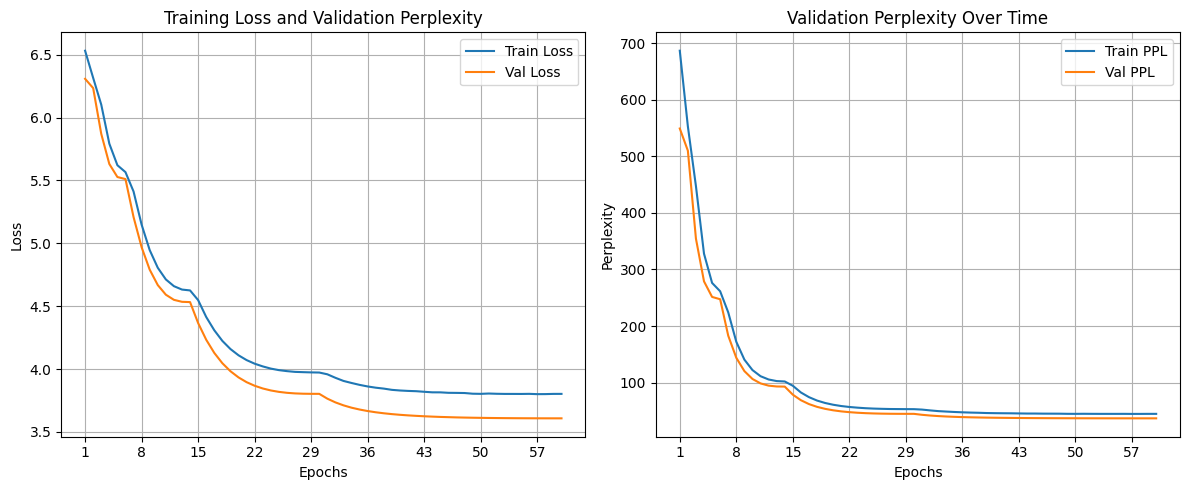

In [ ]:
# make train_loss, train_ppl, val_ppl, val_loss and epochs into a DataFrame
history = train_results["history"]
history_df = pd.DataFrame({
    "train_loss": history["train_loss"],
    "train_ppl": history["train_ppl"],
    "val_ppl": history["val_ppl"],
    "val_loss": history["val_loss"],
    "epochs": range(1, len(history["train_loss"]) + 1)
})

display(history_df.head())
display(history_df.tail())
# plot results 
history = train_results["history"]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['epochs'], history_df["train_loss"], label="Train Loss")
plt.plot(history_df['epochs'], history_df["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(history_df['epochs'][::int(len(history_df['epochs'])//9)+1])  
plt.title("Training Loss and Validation Perplexity")
plt.legend()
plt.grid()

# plot perplexity
plt.subplot(1, 2, 2)
plt.plot(history_df['epochs'], history_df["train_ppl"], label="Train PPL")
plt.plot(history_df['epochs'], history_df["val_ppl"], label="Val PPL")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.xticks(history_df['epochs'][::int(len(history_df['epochs'])//9)+1])  
plt.title("Validation Perplexity Over Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [13]:
@torch.no_grad()
def compute_perplexity_rigid(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    # get logits, convert to probabilities with softmax, and compute perplexity explicitly
    model.eval()
    total_nll = 0.0  # summed CE over all tokens
    total_tok = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x, logits=True)
        B, T, V = logits.shape
        probs = F.softmax(logits, dim=-1)  # (B, T, V)
        # compute NLL
        nll_sum = -torch.sum(torch.log(probs.gather(-1, y.unsqueeze(-1)).squeeze(-1)), dim=-1).sum()
        total_nll += nll_sum.item()
        total_tok += B * T

    mean_nll = total_nll / max(1, total_tok)  # per-token nats
    return np.exp(mean_nll)

In [ ]:
# load the best model
best_ckpt = os.path.join(CHECKPOINT_DIR, f"{ckpt_file_prefix}best_{N_MERGES}.pt")
full_cfg_file = os.path.join(best_ckpt.split(".")[0]+"_hparams.json")
    
if os.path.exists(best_ckpt):
    ckpt = torch.load(best_ckpt, map_location="cpu", weights_only=False)
    # create a new model instance that matches the best checkpoint
    print(ckpt.keys())
    loaded_model = NeuralBigram(vocab_size, embedding_dim=D_EMBED, use_output_layer=USE_OUTPUT_LAYER)
    # load the model state dict
    loaded_model.load_state_dict(ckpt["model"])
    print(f"Loaded model with {count_params(loaded_model):,} parameters from {best_ckpt}")
    
    # evaluate the loaded model
    val_avg_loss = evaluate(loaded_model, val_loader, device=torch.device("cpu"))
    train_avg_loss = evaluate(loaded_model, train_loader, device=torch.device("cpu"))
    val_ppl = np.exp(val_avg_loss)
    train_ppl = np.exp(train_avg_loss)
    explicit_val_ppl = compute_perplexity_rigid(loaded_model, val_loader, device=torch.device("cpu"))
    explicit_train_ppl = compute_perplexity_rigid(loaded_model, train_loader, device=torch.device("cpu"))
    
    print(f"Train Loss: {train_avg_loss:.4f} | Train PPL: {train_ppl:.2f}")
    print(f"Validation Loss: {val_avg_loss:.4f} | Validation PPL: {val_ppl:.2f}")
    print(f"Explicit Train PPL: {explicit_train_ppl:.2f} | Explicit Val PPL: {explicit_val_ppl:.2f}")

    test_avg_loss = evaluate(loaded_model, test_loader, device=torch.device("cpu"))
    test_ppl = np.exp(test_avg_loss)
    explicit_test_ppl = compute_perplexity_rigid(loaded_model, test_loader, device=torch.device("cpu"))
    print(f"Test Loss: {test_avg_loss:.4f} | Test PPL: {test_ppl:.2f}, Explicit Test PPL: {explicit_test_ppl:.2f}")

# generate from the loaded model
context = "To be, or not"
context_ids = encode(context).ids
context_ids = torch.tensor(context_ids, dtype=torch.long).unsqueeze(0)  # (1, T_in)
print("Generating from loaded model:")
print("\nContext: ", decode(context_ids[0].tolist()))
rep_penalty = 1.5
generated_ids = loaded_model.generate(context_ids, max_new_tokens=50, mode="argmax", 
                                      repetition_penalty=rep_penalty,
                         eos_id=EOS_TOKEN_ID)
print(f"\nGenerated text:\nargmax with repetition_penalty={rep_penalty}\n")
print(decode(generated_ids[0].tolist()))

top_k = 20
temperature = 1.3
generated_ids = loaded_model.generate(context_ids, max_new_tokens=50, mode="sample", 
                         top_k=20, temperature=1.3,
                         eos_id=EOS_TOKEN_ID)
print(f"\nGenerated text:\nsample with top_k={top_k}, t={temperature}\n")
print(decode(generated_ids[0].tolist()))

dict_keys(['epoch', 'model', 'optimizer', 'scheduler', 'scaler', 'best_val_ppl', 'no_improve', 'config'])
Loaded model with 1,086,500 parameters from checkpoints/neural_bigram/nbigram_withOut_best_800.pt
Train Loss: 3.9377 | Train PPL: 51.30
Validation Loss: 4.2266 | Validation PPL: 68.48
Explicit Train PPL: 51.30 | Explicit Val PPL: 68.48
Test Loss: 4.2481 | Test PPL: 69.97, Explicit Test PPL: 69.97
Generating from loaded model:

Context:   To be, or not

Generated text:
argmax with repetition_penalty=1.5

 To be, or not Citizen, and the cought, I'll tell me, and the first, and the mistress, and the country, and the casters, and the cought, and the cought

Generated text:
sample with top_k=20, t=1.3

 To be, or notest: He is a tabrainisdays, and my turn and my love, if he is crive it. Sirature you not, sir,-- CLEOPATRA, incremy, thou sha


### hyperparameters search

In [99]:
# hyperparam_search.py
import os, json, time, uuid
from dataclasses import dataclass
from typing import Dict, Any, Iterable, Optional, List
from functools import partial

import torch
from torch.optim import AdamW
from torch.amp import GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import pandas as pd

# ---------- Tokenizer train+encode (cached by merges) ----------
def _train_and_encode_tokenizer(
    *,
    tokenizer_trainer,              # e.g. train_bytelevel_bpe
    train_text_path: str,
    val_text_path: str,
    merges: int,
    min_frequency: int,
    lowercase: bool,
    add_prefix_space: bool,
    special_tokens: dict,
    name_prefix: str = "bpe"
) -> Dict[str, Any]:
    with open(train_text_path, "r", encoding="utf-8") as f:
        train_text = f.read()
    with open(val_text_path, "r", encoding="utf-8") as f:
        val_text = f.read()

    tok = tokenizer_trainer(
        files=[train_text_path],
        merges=merges,
        min_frequency=min_frequency,
        lowercase=lowercase,
        add_prefix_space=add_prefix_space,
        name=f"{name_prefix}_{merges}",
        special_tokens=special_tokens
    )
    encode = partial(tok.encode, add_special_tokens=False)
    pad_id = tok.token_to_id(special_tokens.get("pad", "<pad>"))

    train_ids = encode(train_text).ids
    val_ids   = encode(val_text).ids

    chars_per_token_val     = (len(val_text) / max(1, len(val_ids))) if len(val_ids)>0 else float("inf")
    tokens_per_1k_chars_val = (len(val_ids) / max(1, len(val_text)/1000.0)) if len(val_text)>0 else float("inf")

    return {
        "tokenizer": tok,
        "train_ids": train_ids,
        "val_ids": val_ids,
        "pad_id": pad_id if pad_id is not None else 0,
        "vocab_size": tok.get_vocab_size(),
        "chars_per_token_val": chars_per_token_val,
        "tokens_per_1k_chars_val": tokens_per_1k_chars_val,
    }

# ---------- Utilities ----------
def _trial_run_name(base: str = "sweep") -> str:
    return f"{base}_{time.strftime('%Y%m%d-%H%M%S')}_{uuid.uuid4().hex[:8]}"

def _safe_lr_sched(name: str, optimizer, total_steps: int, eta_min: float):
    name = name.lower()
    if name == "cosine":
        return CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=eta_min)
    if name == "cosine_restarts":
        return CosineAnnealingWarmRestarts(optimizer, T_0=max(2, total_steps//10), T_mult=2, eta_min=eta_min)
    if name == "cosine_warmup":
        return WarmupThenCosine(optimizer, warmup_steps=500, total_steps=total_steps, eta_min=eta_min)
    raise ValueError(f"Unknown scheduler: {name}")

# ---------- The Sweep ----------
@dataclass
class hparamsSpace:
    merges: Iterable[int] = (10, 200, 800)
    lr: Iterable[float] = (3e-4, 3e-3, 3e-2)
    dropout: Iterable[float] = (0.0, 0.1, 0.2)
    d_embed: Iterable[int] = (128, 512, 1024)
    use_output_layer: Iterable[bool] = (True, False)
    weight_decay: Iterable[float] = (0.0, 1e-4)
    lr_scheduler: Iterable[str] = ("cosine", "cosine_warmup")  # or ("cosine", "cosine_restarts")

def hparams_search(
    *,
    space: hparamsSpace,
    # training
    base_cfg: TrainConfig,
    train_text_path: str,
    val_text_path: str,
    # tokenizer
    tokenizer_trainer,                   # train_bytelevel_bpe
    special_tokens: dict,
    min_frequency: int = 2,
    lowercase: bool = False,
    add_prefix_space: bool = True,
    # data
    batch_size: int = 32,
    block_size: int = 128,
    shuffle_train: bool = True,
    # lr scheduler
    eta_min: float = 1e-6,
    # sweep space
    # I/O
    csv_log_path: Optional[str] = "sweep_results.csv",
    verbose: bool = False,
):
    os.makedirs(base_cfg.log_dir, exist_ok=True)
    os.makedirs(base_cfg.ckpt_dir, exist_ok=True)

    # cache tokenizers per merges to avoid retraining
    tok_cache: Dict[int, Dict[str, Any]] = {}

    rows: List[Dict[str, Any]] = []
    total_trials = (
        len(tuple(space.merges)) *
        len(tuple(space.lr)) *
        len(tuple(space.dropout)) *
        len(tuple(space.d_embed)) *
        len(tuple(space.use_output_layer)) *
        len(tuple(space.weight_decay)) *
        len(tuple(space.lr_scheduler))
    )
    pbar_all = tqdm(total=total_trials, desc="HParams Search", leave=True, unit="trial")

    for merges in space.merges:
        if merges not in tok_cache:
            tok_cache[merges] = _train_and_encode_tokenizer(
                tokenizer_trainer=tokenizer_trainer,
                train_text_path=train_text_path,
                val_text_path=val_text_path,
                merges=merges,
                min_frequency=min_frequency,
                lowercase=lowercase,
                add_prefix_space=add_prefix_space,
                special_tokens=special_tokens,
                name_prefix="bpe"
            )
        tok_info = tok_cache[merges]
        train_ids = tok_info["train_ids"]
        val_ids   = tok_info["val_ids"]
        vocab_sz  = tok_info["vocab_size"]

        # dataloaders
        train_loader = init_dataloader(train_ids, block_size, batch_size, train=True, shuffle=shuffle_train)
        val_loader   = init_dataloader(val_ids,   block_size, batch_size, train=False, shuffle=False)

        for lr in space.lr:
            for dropout in space.dropout:
                for d_embed in space.d_embed:
                    for use_output_layer in space.use_output_layer:
                        for weight_decay in space.weight_decay:
                            for sched_name in space.lr_scheduler:
                                run_name = _trial_run_name("hps")
                                run_dir  = os.path.join(base_cfg.log_dir, run_name)
                                writer   = SummaryWriter(log_dir=run_dir, flush_secs=5)

                                # Build model
                                model = NeuralBigram(
                                    vocab_size=vocab_sz,
                                    embedding_dim=d_embed,
                                    use_output_layer=use_output_layer,
                                    dropout=dropout
                                )
                                dev = base_cfg.device
                                model.to(dev)

                                # Optimizer & Scheduler
                                optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
                                total_steps = base_cfg.epochs * max(1, len(train_loader)//max(1, base_cfg.grad_accum_steps))
                                lr_scheduler = _safe_lr_sched(sched_name, optimizer, total_steps, eta_min)

                                scaler = GradScaler(enabled=base_cfg.use_amp)

                                # Compose per-trial TrainConfig (override LR, files, log/ckpt paths)
                                cfg = base_cfg
                                cfg = type(base_cfg)(**{**vars(base_cfg),
                                    "ckpt_best_filename": f"best_{run_name}.pt",
                                    "ckpt_last_filename": f"last_{run_name}.pt",
                                    "log_dir": run_dir,
                                })

                                # Log hparams to TB as text
                                rl_scheduler_state_dict = lr_scheduler.state_dict() if lr_scheduler.__class__.__name__ != "WarmupThenCosine" else {
                                                            k:v for k, v in lr_scheduler.state_dict().items() if k != "cosine"}
                                hparams_json = {
                                    "tokenizer": {
                                        "merges": merges,
                                        "vocab_size": vocab_sz,
                                        "min_frequency": min_frequency,
                                        "lowercase": lowercase,
                                        "add_prefix_space": add_prefix_space,
                                    },
                                    "data": {
                                        "batch_size": batch_size,
                                        "block_size": block_size,
                                        "shuffle_train": shuffle_train,
                                    },
                                    "model": {
                                        "d_input": vocab_sz,
                                        "d_embed": d_embed,
                                        "use_output_layer": use_output_layer,
                                        "dropout": dropout,
                                    },
                                    "optimizer": {"name": optimizer.__class__.__name__,
                                        **optimizer.defaults},
                                    "rl_scheduler": {"name": lr_scheduler.__class__.__name__,
                                        **rl_scheduler_state_dict
                                    },                                                     
                                    "SCALER": {"name": scaler.__class__.__name__,
                                        "enabled": cfg.use_amp,},
                                    "training": vars(cfg).copy(),
                                }

                                full_config_file = os.path.join(base_cfg.ckpt_dir, f"{run_name}_hparams.json")
                                with open(full_config_file, "w") as f:
                                    json.dump(hparams_json, f, indent=4)

                                writer.add_text("config/json", "```json\n" + json.dumps(hparams_json, indent=2) + "\n```", 0)

                                # Train
                                out = train(
                                    model=model,
                                    train_loader=train_loader,
                                    val_loader=val_loader,
                                    cfg=cfg,
                                    optimizer=optimizer,
                                    scheduler=lr_scheduler,
                                    scaler=scaler,
                                    writer=writer,
                                )
                                writer.close()

                                # Collect final metrics
                                row = {
                                    "run": run_name,
                                    "merges": merges,
                                    "vocab_size": vocab_sz,
                                    "lr": lr,
                                    "dropout": dropout,
                                    "d_embed": d_embed,
                                    "use_output_layer": use_output_layer,
                                    "weight_decay": weight_decay,
                                    "scheduler": sched_name,
                                    "val_ppl": out["best_val_ppl"],
                                    "train_ppl": out["history"]["train_ppl"][-1],
                                    "val_loss": out["history"]["val_loss"][-1],
                                    "train_loss": out["history"]["train_loss"][-1],
                                    "epochs": out["last_epoch"] + 1,
                                    "ckpt_best": os.path.join(base_cfg.ckpt_dir, out["ckpt_best"]),
                                    "ckpt_last": os.path.join(base_cfg.ckpt_dir, out["ckpt_last"]),
                                    'full_config_file': full_config_file,
                                }
                                rows.append(row)

                                if verbose:
                                    print(f"[{run_name}] k={merges}, d={d_embed}, lr={lr:.1e}, drop={dropout}, "
                                          f"wd={weight_decay}, sched={sched_name} -> val_ppl {row['val_ppl']:.2f}")
                                
                                pbar_all.set_postfix(
                                    val_ppl=f"{row['val_ppl']:.2f}",
                                    merges=merges,
                                    d_embed=d_embed,
                                    lr=f"{lr:.1e}",
                                    dropout=dropout,
                                    use_output_layer=use_output_layer,
                                    weight_decay=weight_decay,
                                    scheduler=sched_name,
                                )
                                pbar_all.update(1)

    pbar_all.close()
    df = pd.DataFrame(rows).sort_values(["val_ppl", "merges", "d_embed", "lr"]).reset_index(drop=True)
    if csv_log_path:
        df.to_csv(csv_log_path, index=False)
    return df


In [100]:
SEED = 10
# hyperparameters 
# data
BATCH_SIZE = 32
BLOCK_SIZE = 128
SHUFFLE_TRAIN = True

#  model
D_EMBED = 512
USE_OUTPUT_LAYER = False  # if false, d_embed == vocab_size and no output layer is used
DROPOUT = 0.1
# optimizer
LR = 3e-3
WEIGHT_DECAY = 1e-4
# scheduler
ETA_MIN = 1e-8

# training loop
EPOCHS = 60
ES_PATIENCE = 5
ES_TOLERANCE = 1e-6
GRAD_ACCUM_STEPS = 1
USE_AMP = False # IMPORTANT: set to False if training on CPU training 

# checkpoints
CKPT_N_EPOCHS = 5  # save checkpoint every n epochs
cfg_hparam_search = TrainConfig(device="cuda" if torch.cuda.is_available() else "cpu",
                    epochs=EPOCHS, 
                    early_stop_patience=ES_PATIENCE,
                    early_stop_tolerance=ES_TOLERANCE,
                    grad_accum_steps=GRAD_ACCUM_STEPS,
                    # max_grad_norm=data.get("max_grad_norm", 1.0),
                    use_amp=USE_AMP,
                    seed=SEED,
                    ckpt_n_epochs=CKPT_N_EPOCHS,
                    ckpt_dir=os.path.join(CHECKPOINT_DIR, "hparams_search"),
                    ckpt_best_filename="best.pt",
                    ckpt_last_filename="last.pt",
                    log_dir=os.path.join(LOG_DIR, "hparams_search"),
                    )

nbigram_hp_space = hparamsSpace(
                            # merges=(10, 200, 800,),
                            merges=(10, 200, 800,),
                            lr=(3e-4, 3e-3, 3e-2,),
                            dropout=(0.0, 0.3,),
                            d_embed=(128,),
                            use_output_layer=(False,),
                            weight_decay=(1e-4,),
                            lr_scheduler=("cosine_warmup",),
                            )

total_trials = (
        len(nbigram_hp_space.merges)*
        len(nbigram_hp_space.lr)*
        len(nbigram_hp_space.dropout)*
        len(nbigram_hp_space.d_embed)*
        len(nbigram_hp_space.use_output_layer)*
        len(nbigram_hp_space.weight_decay)*
        len(nbigram_hp_space.lr_scheduler)
    )
print(f"Total trials: {total_trials}")


Total trials: 18


In [102]:
hparams_seach_df = hparams_search(
    space=nbigram_hp_space,
    train_text_path=train_file,
    val_text_path=val_file,
    # tokenizer
    tokenizer_trainer=train_bytelevel_bpe,
    special_tokens=SPECIAL_TOKENS,
    min_frequency=MIN_FREQ,
    # lowercase=False,
    # add_prefix_space=True,
    # data
    batch_size=BATCH_SIZE,
    block_size=BLOCK_SIZE,
    shuffle_train=SHUFFLE_TRAIN,
    # training cfg
    base_cfg=cfg_hparam_search,
    # 
    eta_min=ETA_MIN,
    # I/O
    csv_log_path=os.path.join(RESULTS_DIR, "nBigram_hparams_results.csv"),
    verbose=False,
)




Saved tokenizer to bpe_tok/bpe_10.json | vocab=270 (requested merges=10)





Saved tokenizer to bpe_tok/bpe_200.json | vocab=460 (requested merges=200)





Saved tokenizer to bpe_tok/bpe_800.json | vocab=1060 (requested merges=800)


In [103]:
print(hparams_seach_df.columns)
display(hparams_seach_df.head())
best = hparams_seach_df.iloc[0]
display("Best trial:", best.to_dict())
# save dataframe to CSV
hparam_results_file = os.path.join(RESULTS_DIR, "nBigram_hparams_results_1.csv")
hparams_seach_df.to_csv(hparam_results_file, index=False)

Index(['run', 'merges', 'vocab_size', 'lr', 'dropout', 'd_embed',
       'use_output_layer', 'weight_decay', 'scheduler', 'val_ppl', 'train_ppl',
       'val_loss', 'train_loss', 'epochs', 'ckpt_best', 'ckpt_last',
       'full_config_file'],
      dtype='object')


,run,merges,vocab_size,lr,dropout,d_embed,use_output_layer,weight_decay,scheduler,val_ppl,train_ppl,val_loss,train_loss,epochs,ckpt_best,ckpt_last,full_config_file
0,hps_20250821-141640_ea8d6253,10,270,0.030,0.0,128,False,0.0001,cosine_warmup,14.827009,14.719625,2.696703,2.689182,49,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
1,hps_20250821-141124_f4d0b2a6,10,270,0.003,0.0,128,False,0.0001,cosine_warmup,14.897343,14.785655,2.701183,2.693657,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
2,hps_20250821-141743_f4bb6763,10,270,0.030,0.3,128,False,0.0001,cosine_warmup,15.521814,34.610947,2.742271,3.544170,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
3,hps_20250821-141242_df995f7c,10,270,0.003,0.3,128,False,0.0001,cosine_warmup,16.001373,34.702778,2.772675,3.546820,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
4,hps_20250821-143113_8883dd9c,200,460,0.030,0.0,128,False,0.0001,cosine_warmup,36.264518,34.190120,3.592031,3.531937,20,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...


'Best trial:'

{'run': 'hps_20250821-141640_ea8d6253',
 'merges': 10,
 'vocab_size': 270,
 'lr': 0.03,
 'dropout': 0.0,
 'd_embed': 128,
 'use_output_layer': False,
 'weight_decay': 0.0001,
 'scheduler': 'cosine_warmup',
 'val_ppl': 14.827009456225612,
 'train_ppl': 14.719625424654295,
 'val_loss': 2.696703303703488,
 'train_loss': 2.6891816662822765,
 'epochs': 49,
 'ckpt_best': 'checkpoints/neural_bigram/hparams_search/best_hps_20250821-141640_ea8d6253.pt',
 'ckpt_last': 'checkpoints/neural_bigram/hparams_search/last_hps_20250821-141640_ea8d6253.pt',
 'full_config_file': 'checkpoints/neural_bigram/hparams_search/hps_20250821-141640_ea8d6253_hparams.json'}

In [104]:
# load the dataframe from CSV
hparams_seach_df = pd.read_csv(hparam_results_file)
display(hparams_seach_df.head())

,run,merges,vocab_size,lr,dropout,d_embed,use_output_layer,weight_decay,scheduler,val_ppl,train_ppl,val_loss,train_loss,epochs,ckpt_best,ckpt_last,full_config_file
0,hps_20250821-141640_ea8d6253,10,270,0.030,0.0,128,False,0.0001,cosine_warmup,14.827009,14.719625,2.696703,2.689182,49,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
1,hps_20250821-141124_f4d0b2a6,10,270,0.003,0.0,128,False,0.0001,cosine_warmup,14.897343,14.785655,2.701183,2.693657,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
2,hps_20250821-141743_f4bb6763,10,270,0.030,0.3,128,False,0.0001,cosine_warmup,15.521814,34.610947,2.742271,3.544170,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
3,hps_20250821-141242_df995f7c,10,270,0.003,0.3,128,False,0.0001,cosine_warmup,16.001373,34.702778,2.772675,3.546820,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
4,hps_20250821-143113_8883dd9c,200,460,0.030,0.0,128,False,0.0001,cosine_warmup,36.264518,34.190120,3.592031,3.531937,20,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...


In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps

def plot_hparams_search(
    df: pd.DataFrame,
    *,
    title: str = "HP Sweep — best val_ppl over dropouts (merges x lr)",
    save_path: str | None = None,
    show: bool = True,
    returns: bool = False,
):
    data = df.copy()
    required = {"merges", "lr", "val_ppl"}
    missing = required - set(data.columns)
    if missing:
        raise ValueError(f"df is missing columns: {missing}")
    # Ensure numeric
    for c in ["merges", "lr", "val_ppl"]:
        data[c] = pd.to_numeric(data[c], errors="coerce")
    data = data.dropna(subset=["merges", "lr", "val_ppl"])

    # plot
    fig, axs = plt.subplots(3,2, figsize=(24, 15), constrained_layout=True)
    axs = axs.flatten()  
    cmap = colormaps["plasma"]
    fig.suptitle(title, fontsize=16)

    # heatmap val_pll (merges, lr) over means dropout
    ax_hm = axs[0]
    best = data.groupby(["merges", "lr"], as_index=False)["val_ppl"].min()
    merges_vals = np.sort(best["merges"].unique())
    lr_vals     = np.sort(best["lr"].unique())
    dropout_vals = np.sort(data["dropout"].unique())
    pivot = best.pivot(index="lr", columns="merges", values="val_ppl").reindex(
        index=lr_vals, columns=merges_vals
    )
    im = ax_hm.imshow(pivot.values, aspect="auto", origin="lower", cmap=cmap)
    cbar = fig.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)
    cbar.set_label("val_ppl")
    ax_hm.set_title("HM Best val_ppl by merges and per lr")
    ax_hm.set_xlabel("merges (k)")
    ax_hm.set_ylabel("learning rate (log10 scale)")
    ax_hm.set_xticks(np.arange(len(merges_vals)))
    ax_hm.set_xticklabels([f"{m}" for m in merges_vals], rotation=45, ha="right")
    ax_hm.set_yticks(np.arange(len(lr_vals)))
    ax_hm.set_yticklabels([f"{np.log10(lr):.1f}" for lr in lr_vals])
    ax_hm.set_xlim(-0.5, len(merges_vals) - 1 + 0.5)
    ax_hm.set_ylim(-0.5, len(lr_vals) - 1 + 0.5)
    # annotate best val_ppl overall with an arrow
    best_val_ppl = best["val_ppl"].min()
    best_idx = best["val_ppl"].idxmin()
    best_merges = best.loc[best_idx, "merges"]
    best_lr = best.loc[best_idx, "lr"]
    best_merges_idx = np.where(merges_vals == best_merges)[0][0]
    best_lr_idx = np.where(lr_vals == best_lr)[0][0]
    ax_hm.annotate(f"Best: {best_val_ppl:.2f}",
                   xy=(best_merges_idx, best_lr_idx),
                   xytext=(best_merges_idx + 0.5, best_lr_idx + 0.5),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    color='red', fontsize=12, fontweight='bold',)

    # lineplot for each lr and dropout, take best val_ppl for each (merges, lr) and (merges, dropout)
    ax_line_lr = axs[2]
    best_lr = (data.groupby(["merges","lr"], as_index=False)["val_ppl"]
               .min()
               .sort_values(["lr","merges"]))
    
    for lr in lr_vals:
        sub = best_lr[best_lr["lr"] == lr]
        if len(sub):
            ax_line_lr.plot(sub["merges"], sub["val_ppl"],
                                    marker="o", linewidth=1.8, label=f"lr={lr:.1e}", alpha=0.9)
    ax_line_lr.set_title("Best val_ppl by merges (per lr)")
    ax_line_lr.set_xlabel("merges (k)")
    ax_line_lr.set_ylabel("val_ppl")
    ax_line_lr.grid(alpha=0.7)
    ax_line_lr.legend(title="Learning rate", loc="upper right", fontsize=10)
    # best across lr for each (merges, dropout)
    best_do = (data.groupby(["merges","dropout"], as_index=False)["val_ppl"]
               .min()
               .sort_values(["dropout","merges"]))
    ax_line_dropout = axs[3]
    for d in data["dropout"].unique():
        sub = best_do[best_do["dropout"] == d]
        if len(sub):
            ax_line_dropout.plot(sub["merges"], sub["val_ppl"],
                                    linestyle="--", marker="s", linewidth=1.4,
                                    label=f"dropout={d:g}", alpha=0.8)
    ax_line_dropout.set_title("Best val_ppl by merges (per dropout)")   
    ax_line_dropout.set_xlabel("merges (k)")
    ax_line_dropout.set_ylabel("val_ppl")
    ax_line_dropout.grid(alpha=0.7)
    ax_line_dropout.legend(title="Dropout", loc="upper right", fontsize=10)

    # let both ax 1 and 2 have same y-axis limits
    y_min = min(ax_line_lr.get_ylim()[0], ax_line_dropout.get_ylim()[0])
    y_max = max(ax_line_lr.get_ylim()[1], ax_line_dropout.get_ylim()[1])
    ax_line_lr.set_ylim(y_min, y_max)
    ax_line_dropout.set_ylim(y_min, y_max)
    # plt.tight_layout()
    
    # plot variance of means
    ax_var = axs[1]
    total_var = data["val_ppl"].var(ddof=1) if len(data) > 1 else 0.0
    var_m = data.groupby("merges")["val_ppl"].mean().var(ddof=1) if len(merges_vals) > 1 else 0.0
    var_lr = data.groupby("lr")["val_ppl"].mean().var(ddof=1) if len(lr_vals) > 1 else 0.0
    var_d = data.groupby("dropout")["val_ppl"].mean().var(ddof=1) if len(dropout_vals) > 1 else 0.0
    # interaction terms
    var_m_lr = data.groupby(["merges", "lr"])["val_ppl"].mean().var(ddof=1) if len(merges_vals) > 1 and len(lr_vals) > 1 else 0.0
    var_m_d = data.groupby(["merges", "dropout"])["val_ppl"].mean().var(ddof=1) if len(merges_vals) > 1 and len(dropout_vals) > 1 else 0.0
    var_lr_d = data.groupby(["lr", "dropout"])["val_ppl"].mean().var(ddof=1) if len(lr_vals) > 1 and len(dropout_vals) > 1 else 0.0
    var_m_lr_d = data.groupby(["merges", "lr", "dropout"])["val_ppl"].mean().var(ddof=1) if len(merges_vals) > 1 and len(lr_vals) > 1 and len(dropout_vals) > 1 else 0.0
    parts = np.array([var_m, var_lr, var_d, var_m_lr, var_m_d, var_lr_d], dtype=float)
    if parts.sum() > 0:
        frac = parts / parts.sum()
    else:
        frac = np.zeros_like(parts)
        
    ax_var.barh(["merges", "lr", "dropout", "mergesXlr", "mergesXdropout", "lrXdropout"], frac, color=["tab:blue","tab:green","tab:purple","tab:orange","tab:red","tab:brown","tab:pink"])
    ax_var.set_xlim(0, 1)
    ax_var.set_title("Variance of means (normalized)")
    ax_var.set_xlabel("fraction of variance (~impact)")
    for y, v in enumerate(frac):
        ax_var.text(v + 0.01, y, f"{100*v:.1f}%", va="center")
    ax_var.grid(axis="x", alpha=0.3)
    

    # plot mean epoch for each lr and dropout
    norm_lr = lambda x: (x - np.log10(data["lr"].min())) / (np.log10(data["lr"].max()) - np.log10(data["lr"].min()))
    ax_mean_epoch = axs[4]
    mean_epoch_lr = data.groupby("lr", as_index=False)["epochs"].mean().sort_values("lr")
    ax_mean_epoch.bar(np.arange(len(mean_epoch_lr)), mean_epoch_lr["epochs"],
                      color=[cmap(norm_lr(np.log10(l))) for l in mean_epoch_lr["lr"]])
    ax_mean_epoch.set_title("Mean epochs by lr")
    ax_mean_epoch.set_xlabel("lr")
    ax_mean_epoch.set_ylabel("mean epochs")
    ax_mean_epoch.set_xticks(np.arange(len(mean_epoch_lr)))
    ax_mean_epoch.set_xticklabels([f"{l:.1e}" for l in mean_epoch_lr["lr"]], rotation=45, ha="right")
    ax_mean_epoch.grid(axis="y", alpha=0.3)
    
    # plot generalization gap (val vs train ppl)
    ax_gap = axs[5]

    if {"train_ppl","val_ppl"}.issubset(data.columns):
        # Cgap per run
        data["gap"] = (data["val_ppl"] - data["train_ppl"]) / data["train_ppl"]

        best_gap = (data.groupby(["merges","lr"], as_index=False)
                        .apply(lambda g: g.loc[g["val_ppl"].idxmin()][["gap","val_ppl","train_ppl"]])
                        .reset_index(drop=True))

        # pivot to heatmap
        pivot_gap = best_gap.pivot(index="lr", columns="merges", values="gap")
        merges_vals = np.sort(best_gap["merges"].unique())
        lr_vals     = np.sort(best_gap["lr"].unique())

        im = ax_gap.imshow(pivot_gap.values, aspect="auto", origin="lower", cmap="coolwarm", vmin=-0.5, vmax=0.5)
        cbar = fig.colorbar(im, ax=ax_gap, fraction=0.046, pad=0.04)
        cbar.set_label("Normalized gap (val-train)/train")

        ax_gap.set_title("Generalization Gap Heatmap (best dropout)", pad=8)
        ax_gap.set_xlabel("merges (k)")
        ax_gap.set_ylabel("learning rate (log10 scale)")
        ax_gap.set_xticks(np.arange(len(merges_vals)))
        ax_gap.set_xticklabels([f"{m}" for m in merges_vals], rotation=45, ha="right")
        ax_gap.set_yticks(np.arange(len(lr_vals)))
        ax_gap.set_yticklabels([f"{np.log10(l):.1f}" for l in lr_vals])
        ax_gap.set_xlim(-0.5, len(merges_vals)-0.5)
        ax_gap.set_ylim(-0.5, len(lr_vals)-0.5)

        # annotate hm 
        for i, lr in enumerate(lr_vals):
            for j, m in enumerate(merges_vals):
                val = pivot_gap.loc[lr, m]
                if pd.notna(val):
                    ax_gap.text(j, i, f"{val:+.2f}", ha="center", va="center", fontsize=8, color="black")

    if save_path:
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")

    if show:
        plt.show()

    if returns:
        return fig, ax_hm, pivot


/tmp/ipykernel_353999/592347042.py:151: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g["val_ppl"].idxmin()][["gap","val_ppl","train_ppl"]])


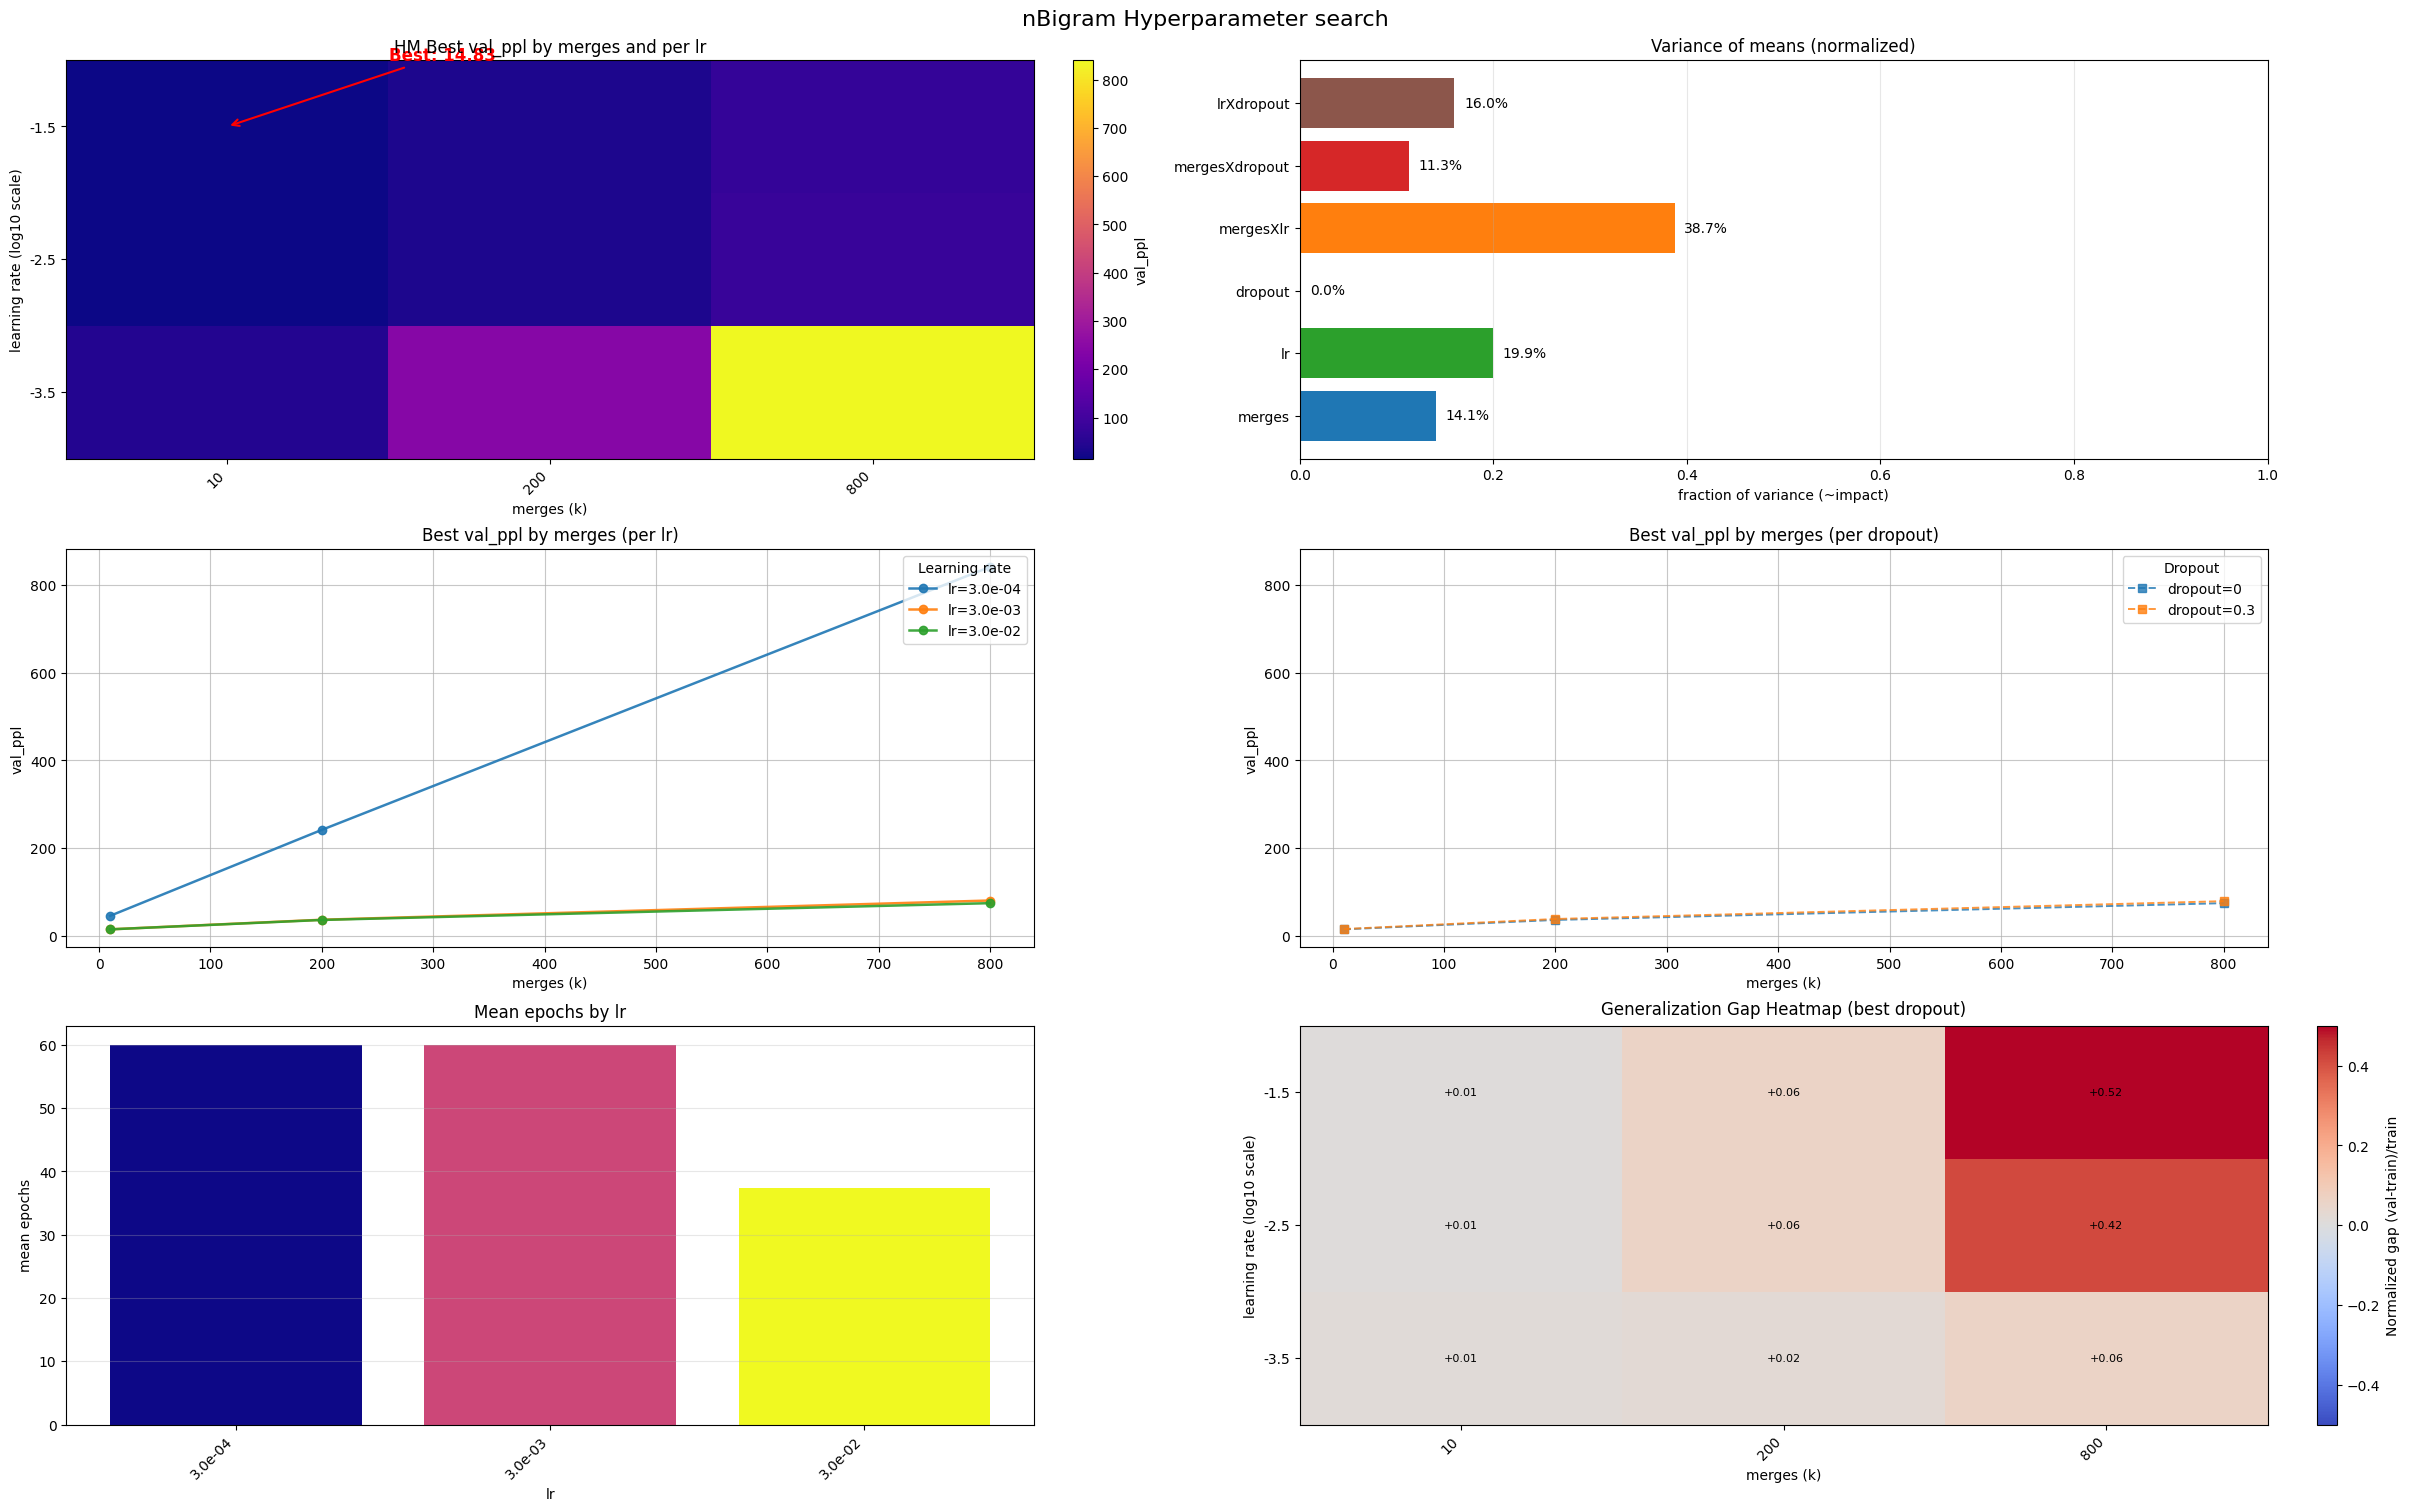

In [106]:
plot_hparams_search(
    hparams_seach_df,
    title="nBigram Hyperparameter search",
    save_path=os.path.join(RESULTS_DIR, "nBigram_hparams_heatmap.png"),
    show=True,
    returns=False,
)

### eval on test and generate text

In [107]:
# load the dataframe from CSV
hparams_seach_df = pd.read_csv(os.path.join(RESULTS_DIR, "nBigram_hparams_results.csv"))
display(hparams_seach_df.head())

,run,merges,vocab_size,lr,dropout,d_embed,use_output_layer,weight_decay,scheduler,val_ppl,train_ppl,val_loss,train_loss,epochs,ckpt_best,ckpt_last,full_config_file
0,hps_20250821-141640_ea8d6253,10,270,0.030,0.0,128,False,0.0001,cosine_warmup,14.827009,14.719625,2.696703,2.689182,49,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
1,hps_20250821-141124_f4d0b2a6,10,270,0.003,0.0,128,False,0.0001,cosine_warmup,14.897343,14.785655,2.701183,2.693657,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
2,hps_20250821-141743_f4bb6763,10,270,0.030,0.3,128,False,0.0001,cosine_warmup,15.521814,34.610947,2.742271,3.544170,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
3,hps_20250821-141242_df995f7c,10,270,0.003,0.3,128,False,0.0001,cosine_warmup,16.001373,34.702778,2.772675,3.546820,60,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...
4,hps_20250821-143113_8883dd9c,200,460,0.030,0.0,128,False,0.0001,cosine_warmup,36.264518,34.190120,3.592031,3.531937,20,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/last_...,checkpoints/neural_bigram/hparams_search/hps_2...


In [142]:
# sort results by val_ppl
hparams_seach__sorted = hparams_seach_df.sort_values(by="val_ppl").reset_index(drop=True)
hparams_seach__sorted = hparams_seach__sorted[['val_ppl', 'train_ppl', 'merges', 'lr', 'dropout', 'run', 'ckpt_best', 'full_config_file']]
print("Best hyperparameters:")
display(hparams_seach__sorted.head(1))

# get best hyperparameters per merges
best_per_merges = hparams_seach__sorted.loc[hparams_seach__sorted.groupby("merges")["val_ppl"].idxmin()].reset_index(drop=True)
best_per_merges = best_per_merges[['val_ppl', 'train_ppl', 'merges', 'lr', 'dropout','run', 'ckpt_best', 'full_config_file']]
best_per_merges = best_per_merges.sort_values(by="merges").reset_index(drop=True)
print("Best hyperparameters per merges:")
display(best_per_merges)

Best hyperparameters:


,val_ppl,train_ppl,merges,lr,dropout,run,ckpt_best,full_config_file
0,14.827009,14.719625,10,0.03,0.0,hps_20250821-141640_ea8d6253,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/hps_2...


Best hyperparameters per merges:


,val_ppl,train_ppl,merges,lr,dropout,run,ckpt_best,full_config_file
0,14.827009,14.719625,10,0.03,0.0,hps_20250821-141640_ea8d6253,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/hps_2...
1,36.264518,34.190120,200,0.03,0.0,hps_20250821-143113_8883dd9c,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/hps_2...
2,74.533152,49.193149,800,0.03,0.0,hps_20250821-145039_cda7cfef,checkpoints/neural_bigram/hparams_search/best_...,checkpoints/neural_bigram/hparams_search/hps_2...


In [168]:
test_runs = []
# load the best model for each merges
for merges in best_per_merges["merges"].unique():
    best_row = best_per_merges[best_per_merges["merges"] == merges].iloc[0]
    run_name = best_row["run"]
    ckpt_path = os.path.join(best_row['ckpt_best'])
    print(f"Loading best model for merges={merges} from {ckpt_path}")
    full_cfg_file = best_row['full_config_file']
    full_cfg_ = json.load(open(os.path.join(full_cfg_file), "r"))
    print(f"Loaded config from {full_cfg_file}")
    ckpt = load_checkpoint(ckpt_path, map_location=full_cfg_["training"]["device"], weights_only=False)
    
    # tokenizer 
    tokenizer = train_bytelevel_bpe(
        files=[train_file],
        merges=merges,
        min_frequency=full_cfg_['tokenizer'].get("min_frequency", 2),
        lowercase=full_cfg_['tokenizer'].get("lowercase", False),
        add_prefix_space=full_cfg_['tokenizer'].get("add_prefix_space", True),
        special_tokens=full_cfg_['tokenizer'].get("special_tokens", SPECIAL_TOKENS),
    )
    encode = partial(tokenizer.encode, add_special_tokens=False)
    pad_id = tokenizer.token_to_id(SPECIAL_TOKENS.get("bos", "<bos>"))
    decode = tokenizer.decode
    vocab_size = tokenizer.get_vocab_size()
    
    # data
    # train_ids = encode(train_text).ids
    # val_ids = encode(val_text).ids
    test_ids = encode(test_text).ids

    test_loader = init_dataloader(
        test_ids, 
        block_size=full_cfg_['data']["block_size"],
        batch_size=full_cfg_['data']["batch_size"],
        train=False, 
    )
    # model
    model = NeuralBigram(
        vocab_size=full_cfg_['model']["d_input"],
        embedding_dim=full_cfg_['model']["d_embed"],
        use_output_layer=full_cfg_['model']["use_output_layer"],
        dropout=full_cfg_['model']["dropout"],
    )
    model.load_state_dict(ckpt["model"])
    model.to(full_cfg_["training"]["device"])

    # get optimizer dynamicly from his class name
    optimizer_class = getattr(torch.optim, full_cfg_['optimizer']['name'])
    optimizer = optimizer_class(model.parameters(), lr=full_cfg_['optimizer']['lr'],)
    optimizer.defaults.update({k:v for k,v in full_cfg_['optimizer'].items() if k != 'name'})  # update optimizer defaults with full config
    # get scheduler dynamicly from his class name
    if full_cfg_['rl_scheduler']['name'] == "WarmupThenCosine":
        lr_scheduler_class = WarmupThenCosine
        lr_scheduler = lr_scheduler_class(optimizer, warmup_steps=full_cfg_['rl_scheduler']['warmup_steps'],
                                          total_steps=full_cfg_['rl_scheduler']['total_steps'],
                                          eta_min=full_cfg_['rl_scheduler']['eta_min'])
    else:
        lr_scheduler_class = getattr(torch.optim.lr_scheduler, full_cfg_['rl_scheduler']['name'])
        lr_scheduler = lr_scheduler_class(optimizer)
        lr_scheduler.load_state_dict({k:v for k,v in full_cfg_['rl_scheduler'].items() if k != 'name'})  # update scheduler state dict with full config

    # get scaler dynamicly from his class name
    scaler_class = getattr(torch.amp, full_cfg_['SCALER']['name'])
    scaler = scaler_class(enabled=full_cfg_['training']['use_amp'])

    # evaluate the loaded model
    test_avg_loss = evaluate(model, test_loader, device=torch.device(full_cfg_["training"]["device"]))
    test_ppl = np.exp(test_avg_loss)
    
    
    # generate from the loaded model
    context = "To be, or not"
    context_ids = encode(context).ids
    context_ids = torch.tensor(context_ids, dtype=torch.long).unsqueeze(0)  # (1, T_in)
    print("Generating from loaded model with:")
    print(f"merges={merges}, lr={full_cfg_['optimizer']['lr']:.6e}, dropout={full_cfg_['model']['dropout']}")
    print("model parameters count: ", count_params(model))
    print(f"Test PPL: {test_ppl:.2f}, val PPL: {best_row['val_ppl']:.2f}, train PPL: {best_row.get('train_ppl', None)}\n")

    # print(f"Tokenizer: merges={merges}, min_frequency={full_cfg_['tokenizer'].get('min_frequency', 2)}, ")
    # print(f"model: d_input={full_cfg_['model']['d_input']} d_embed={full_cfg_['model']['d_embed']}, use_output_layer={full_cfg_['model']['use_output_layer']}, dropout={full_cfg_['model']['dropout']}")
    # print(f"Optimizer: {optimizer.__class__.__name__}, lr={optimizer.defaults['lr']}, weight_decay={optimizer.defaults.get('weight_decay', 0.0)}")
    # print(f"Scheduler: {lr_scheduler.__class__.__name__}, eta_min={lr_scheduler.state_dict().get('eta_min', 0.0)}")
    # print(f"SCALER: {scaler.__class__.__name__}, enabled={scaler.is_enabled()}")

    print("\nContext: ", decode(context_ids[0].tolist()))
    rep_penalty = 1.5
    generated_ids = model.generate(context_ids, max_new_tokens=50, mode="argmax", 
                                      repetition_penalty=rep_penalty,
                         eos_id=tokenizer.token_to_id(SPECIAL_TOKENS.get("eos", "<eos>")))
    print(f"\nGenerated text:\nargmax with repetition_penalty={rep_penalty}\n")
    print(decode(generated_ids[0].tolist()))

    top_k = 20
    temperature = 1.3
    generated_ids = model.generate(context_ids, max_new_tokens=50, mode="sample", 
                         top_k=top_k, temperature=temperature,
                         eos_id=tokenizer.token_to_id(SPECIAL_TOKENS.get("eos", "<eos>")))
    print(f"\nGenerated text:\nsample with top_k={top_k}, t={temperature}\n")
    print(decode(generated_ids[0].tolist()))
    print("-"* 120 , "\n")

    test_runs.append({
        "test_loss": test_avg_loss,
        "test_ppl": test_ppl,
        "val_ppl": best_row["val_ppl"],
        "train_ppl": best_row.get("train_ppl", None),
        "merges": merges,
        "lr": full_cfg_['optimizer']['lr'],
        "dropout": full_cfg_['model']['dropout'],
        "model_params_count": count_params(model),
        "run_name": run_name,
        "ckpt_path": ckpt_path,
        'train_ppl': best_row.get("train_ppl", None),
        "generated_text_argmax": decode(generated_ids[0].tolist()),
        "generated_text_sample": decode(generated_ids[0].tolist()),
        "context": context,
    })
test_runs = pd.DataFrame(test_runs)
test_runs = test_runs.sort_values(by="test_ppl").reset_index(drop=True)
display(test_runs)

Loading best model for merges=10 from checkpoints/neural_bigram/hparams_search/best_hps_20250821-141640_ea8d6253.pt
Loaded config from checkpoints/neural_bigram/hparams_search/hps_20250821-141640_ea8d6253_hparams.json



Generating from loaded model with:
merges=10, lr=3.000000e-02, dropout=0.0
model parameters count:  72900
Test PPL: 14.57, val PPL: 14.83, train PPL: 14.719625424654296


Context:   To be, or not

Generated text:
argmax with repetition_penalty=1.5

 To be, or not I f d chis llllllllllllllllllllllllllllllllllllll

Generated text:
sample with top_k=20, t=1.3

 To be, or nott thavedrte my ap'elont there, the slld nd. hal. oo myse pe An
------------------------------------------------------------------------------------------------------------------------ 

Loading best model for merges=200 from checkpoints/neural_bigram/hparams_search/best_hps_20250821-143113_8883dd9c.pt
Loaded config from checkpoints/neural_bigram/hparams_search/hps_20250821-143113_8883dd9c_hparams.json


,test_loss,test_ppl,val_ppl,train_ppl,merges,lr,dropout,model_params_count,run_name,ckpt_path,generated_text_argmax,generated_text_sample,context
0,2.679166,14.572941,14.827009,14.719625,10,0.03,0.0,72900,hps_20250821-141640_ea8d6253,checkpoints/neural_bigram/hparams_search/best_...,"To be, or nott thavedrte my ap'elont there, t...","To be, or nott thavedrte my ap'elont there, t...","To be, or not"
1,3.565967,35.373629,36.264518,34.190120,200,0.03,0.0,211600,hps_20250821-143113_8883dd9c,checkpoints/neural_bigram/hparams_search/best_...,"To be, or not, aged too, some would not to a ...","To be, or not, aged too, some would not to a ...","To be, or not"
2,4.330981,76.018788,74.533152,49.193149,800,0.03,0.0,1123600,hps_20250821-145039_cda7cfef,checkpoints/neural_bigram/hparams_search/best_...,"To be, or not? HAMLET Why, I dros of her mast...","To be, or not? HAMLET Why, I dros of her mast...","To be, or not"


In [169]:
# save test text outputs to txt file
test_performance_file = os.path.join(RESULTS_DIR, "nBigram_test_performance.txt")
with open(test_performance_file, "w", encoding="utf-8") as f:
    for idx, run in test_runs.iterrows():
        f.write(f"merges={run['merges']}, lr={run['lr']:.6e}, dropout={run['dropout']}\n")
        f.write(f"model parameters count: {run['model_params_count']}\n")
        f.write(f"Test PPL: {run['test_ppl']:.2f}, val PPL: {run['val_ppl']:.2f}, train PPL: {run.get('train_ppl', None)}\n")
        f.write(f"Context: {run['context']}\n")
        f.write(f"Generated text (argmax): {run['generated_text_argmax']}\n")
        f.write(f"Generated text (sample): {run['generated_text_sample']}\n")
        f.write("-" * 120 + "\n")
    print(f"Saved test performance to {test_performance_file}")
    f.close()

Saved test performance to results/neural_bigram/nBigram_test_performance.txt


,merges,lr,dropout,train_ppl,val_ppl,test_ppl
0,10,0.03,0.0,14.719625,14.827009,14.572941
1,200,0.03,0.0,34.190120,36.264518,35.373629
2,800,0.03,0.0,49.193149,74.533152,76.018788


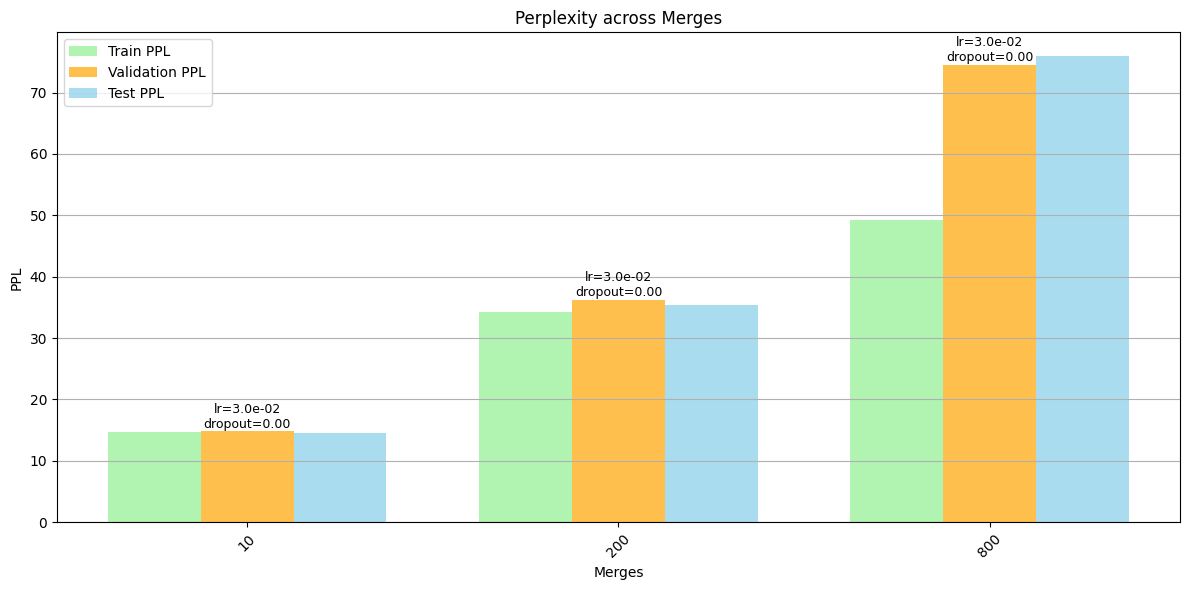

In [173]:
display(test_runs[['merges', 'lr', 'dropout', 'train_ppl', 'val_ppl', 'test_ppl']])
test_runs[['merges', 'lr', 'dropout', 'train_ppl', 'val_ppl', 'test_ppl']].to_csv(os.path.join(RESULTS_DIR, "nBigram_test_performance.csv"), index=False)

x = np.arange(len(best_per_merges['merges']))   
width = 0.25                 

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, best_per_merges['train_ppl'], width, label="Train PPL", color="lightgreen", alpha=0.7)
ax.bar(x,         best_per_merges['val_ppl'],   width, label="Validation PPL", color="orange", alpha=0.7)
ax.bar(x + width, test_runs['test_ppl'],  width, label="Test PPL", color="skyblue", alpha=0.7)

# annotate the bars with the values with lr and dropout
for i, (lr, dropout) in enumerate(zip(best_per_merges['lr'], best_per_merges['dropout'])):
    ax.text(i,         best_per_merges['val_ppl'][i] + 0.1, f"lr={lr:.1e}\ndropout={dropout:.2f}", ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(best_per_merges['merges'], rotation=45)
ax.set_title("Perplexity across Merges")
ax.set_xlabel("Merges")
ax.set_ylabel("PPL")
ax.grid(True, axis='y')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "nBigram_test_results_ppl.png"), dpi=150, bbox_inches="tight")
plt.show()